<a href="https://colab.research.google.com/github/mhdahime-hadoop/MachineLearning/blob/main/ClusteringAppGrocery%26CustomerWeek8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Prepaired by M H Dahime

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
.master("local")\
.appName("ClusteringAppgroceryCustomerWeek8")\
.enableHiveSupport()\
.config('spark.ui.port', '4050')\
.getOrCreate()

In [3]:
path="/content/Grocery.csv"

In [4]:
#Reading  csv file
df = spark.read.csv(path,inferSchema=True,header=True)

In [5]:
df.show(7)
df.count()

+-------+------+-----+----+-------+------+----------------+----------+
|Channel|Region|Fresh|Milk|Grocery|Frozen|Detergents_Paper|Delicassen|
+-------+------+-----+----+-------+------+----------------+----------+
|      2|     3|12669|9656|   7561|   214|            2674|      1338|
|      2|     3| 7057|9810|   9568|  1762|            3293|      1776|
|      2|     3| 6353|8808|   7684|  2405|            3516|      7844|
|      1|     3|13265|1196|   4221|  6404|             507|      1788|
|      2|     3|22615|5410|   7198|  3915|            1777|      5185|
|      2|     3| 9413|8259|   5126|   666|            1795|      1451|
|      2|     3|12126|3199|   6975|   480|            3140|       545|
+-------+------+-----+----+-------+------+----------------+----------+
only showing top 7 rows



440

In [6]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+-------+------+-----+----+-------+------+----------------+----------+
|Channel|Region|Fresh|Milk|Grocery|Frozen|Detergents_Paper|Delicassen|
+-------+------+-----+----+-------+------+----------------+----------+
|      0|     0|    0|   0|      0|     0|               0|         0|
+-------+------+-----+----+-------+------+----------------+----------+



In [7]:
data_df=df.toPandas()

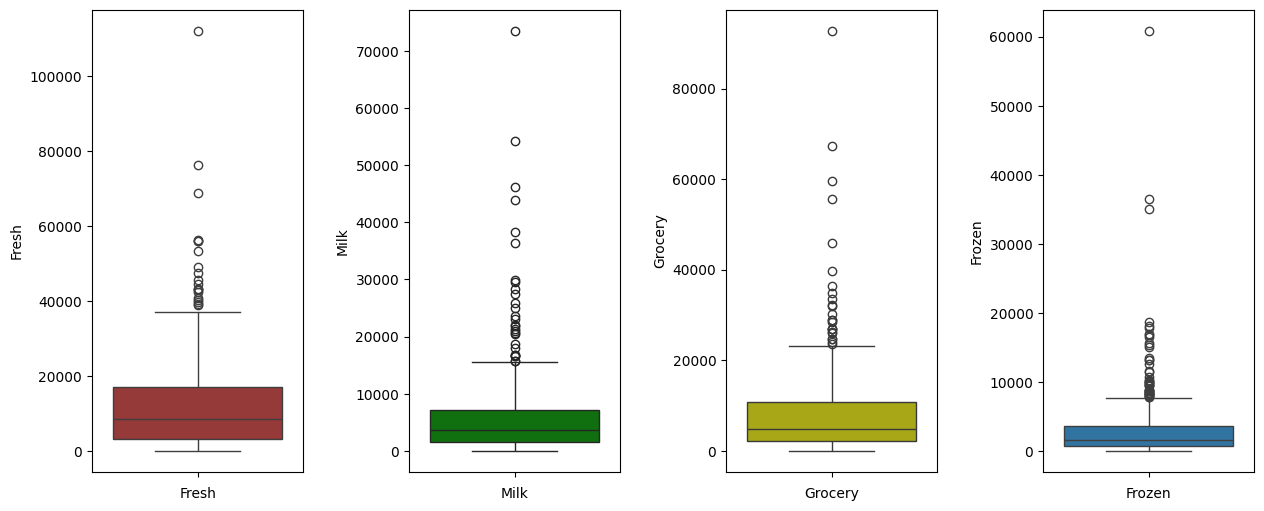

In [9]:
# initialize figure with 4 subplots in a row
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1, 4, figsize=(15, 6))

# add padding between the subplots
plt.subplots_adjust(wspace=0.5)

# draw boxplot for age in the 1st subplot
sns.boxplot(data=data_df['Fresh'], ax=ax[0], color='brown',)
ax[0].set_xlabel('Fresh')

# draw boxplot for station_distance in the 2nd subplot
sns.boxplot(data=data_df['Milk'], ax=ax[1], color='g')
ax[1].set_xlabel('Milk')

# draw boxplot for stores_count in the 3rd subplot
sns.boxplot(data=data_df['Grocery'], ax=ax[2], color='y')
ax[2].set_xlabel('Grocery')

# finally draw boxplot for unit_price in the 4th subplot
sns.boxplot(data=data_df['Frozen'], ax=ax[3])
ax[3].set_xlabel('Frozen')

# by default, you'll see x-tick label set to 0 in each subplot
# remove it by setting it to empty list
for subplot in ax:
    subplot.set_xticklabels([])

plt.show()

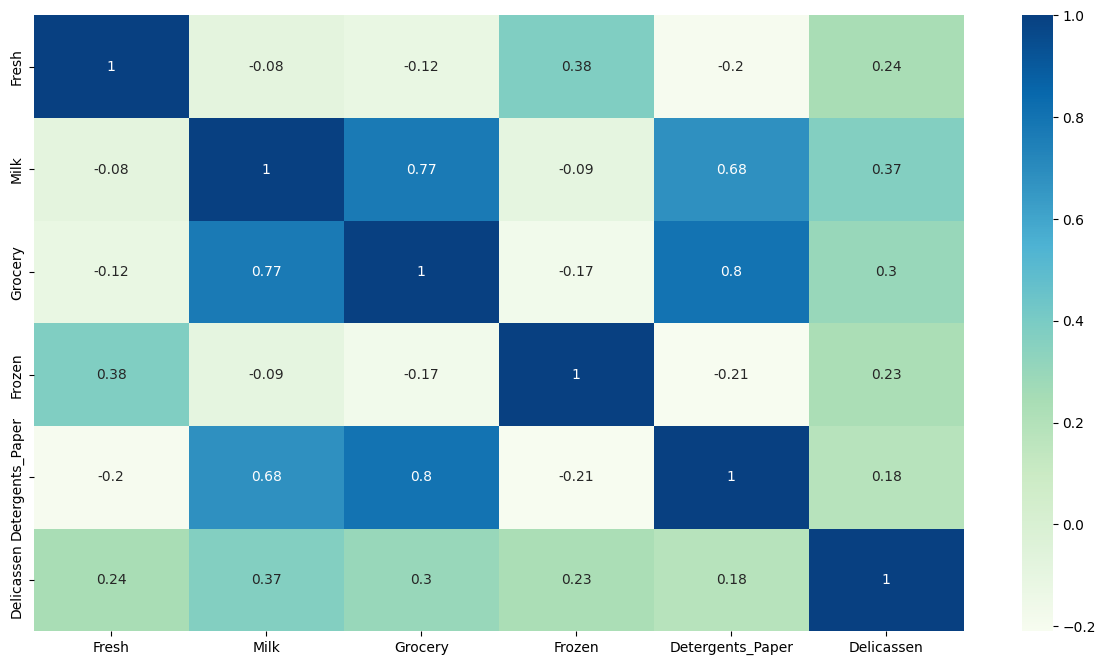

In [10]:
numerical_features = ['Fresh', 'Milk', 'Grocery',
       'Frozen', 'Detergents_Paper', 'Delicassen'
       ]

plt.figure(figsize=(15, 8))
sns.heatmap(round(data_df[numerical_features].corr(method='spearman'), 2),
            annot=True, mask=None, cmap='GnBu')
plt.show()

In [25]:
from pyspark.ml.feature import VectorAssembler
ClusteringColumns = ['Milk', 'Grocery', 'Detergents_Paper']

assembler=VectorAssembler(inputCols=ClusteringColumns, outputCol="features")
featureDf = assembler.transform(df)
featureDf.printSchema()
featureDf.show(10)

root
 |-- Channel: integer (nullable = true)
 |-- Region: integer (nullable = true)
 |-- Fresh: integer (nullable = true)
 |-- Milk: integer (nullable = true)
 |-- Grocery: integer (nullable = true)
 |-- Frozen: integer (nullable = true)
 |-- Detergents_Paper: integer (nullable = true)
 |-- Delicassen: integer (nullable = true)
 |-- features: vector (nullable = true)

+-------+------+-----+-----+-------+------+----------------+----------+--------------------+
|Channel|Region|Fresh| Milk|Grocery|Frozen|Detergents_Paper|Delicassen|            features|
+-------+------+-----+-----+-------+------+----------------+----------+--------------------+
|      2|     3|12669| 9656|   7561|   214|            2674|      1338|[9656.0,7561.0,26...|
|      2|     3| 7057| 9810|   9568|  1762|            3293|      1776|[9810.0,9568.0,32...|
|      2|     3| 6353| 8808|   7684|  2405|            3516|      7844|[8808.0,7684.0,35...|
|      1|     3|13265| 1196|   4221|  6404|             507|      1788|

In [26]:
#preparing data for clustering
featureDf.count()
trainingData, testData = featureDf.randomSplit([0.8, 0.2], seed = 5043)
print(type(trainingData))
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
trainingData.show(10)
testData.columns

<class 'pyspark.sql.dataframe.DataFrame'>
Training Dataset Count: 369
Test Dataset Count: 71
+-------+------+-----+-----+-------+------+----------------+----------+--------------------+
|Channel|Region|Fresh| Milk|Grocery|Frozen|Detergents_Paper|Delicassen|            features|
+-------+------+-----+-----+-------+------+----------------+----------+--------------------+
|      1|     1|  514| 8323|   6869|   529|              93|      1040|[8323.0,6869.0,93.0]|
|      1|     1|  583|  685|   2216|   469|             954|        18|[685.0,2216.0,954.0]|
|      1|     1|  964| 4984|   3316|   937|             409|         7|[4984.0,3316.0,40...|
|      1|     1| 1537| 3748|   5838|  1859|            3381|       806|[3748.0,5838.0,33...|
|      1|     1| 1869|  577|    572|   950|            4762|       203|[577.0,572.0,4762.0]|
|      1|     1| 1956|  891|   5226|  1383|               5|      1328|  [891.0,5226.0,5.0]|
|      1|     1| 2083| 5007|   1563|  1120|             147|      1550

['Channel',
 'Region',
 'Fresh',
 'Milk',
 'Grocery',
 'Frozen',
 'Detergents_Paper',
 'Delicassen',
 'features']

In [47]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
cluster_count = [5]#[10,30,50,70,90]
wssse_values =[]
for i in range(2,6):
  kmeans = KMeans().setK(i).setSeed(1).setFeaturesCol("features").setPredictionCol("prediction")
  kmeansModel = kmeans.fit(trainingData)

  # test the model with test data set
  predictDf = kmeansModel.transform(testData)


  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictDf)

  wssse_values.append(silhouette)
  print("clusters= "+str(i) +" Silhouette with squared euclidean distance: "+ str(silhouette))
  for clusters in kmeansModel.clusterCenters():
    print("cluster centres",clusters)

clusters= 2 Silhouette with squared euclidean distance: 0.8161896823902177
cluster centres [19981.65116279 26478.81395349 11237.09302326]
cluster centres [4040.80674847 5450.67177914 1703.87116564]
clusters= 3 Silhouette with squared euclidean distance: 0.7674397495478554
cluster centres [12474.51851852 18151.86419753  7441.7654321 ]
cluster centres [3358.29225352 4243.46478873 1141.21478873]
cluster centres [53080.75 60015.75 27942.25]
clusters= 4 Silhouette with squared euclidean distance: 0.6861013125654067
cluster centres [ 8552.05 12322.67  4729.23]
cluster centres [2679.86666667 3300.7         787.93333333]
cluster centres [18632.72 26040.4  10594.44]
cluster centres [53080.75 60015.75 27942.25]
clusters= 5 Silhouette with squared euclidean distance: 0.634439766088502
cluster centres [45804.16666667 38194.33333333 15821.33333333]
cluster centres [2424.31674208 2979.00452489  642.21266968]
cluster centres [15045.37142857 22881.94285714  9707.51428571]
cluster centres [46197. 92780

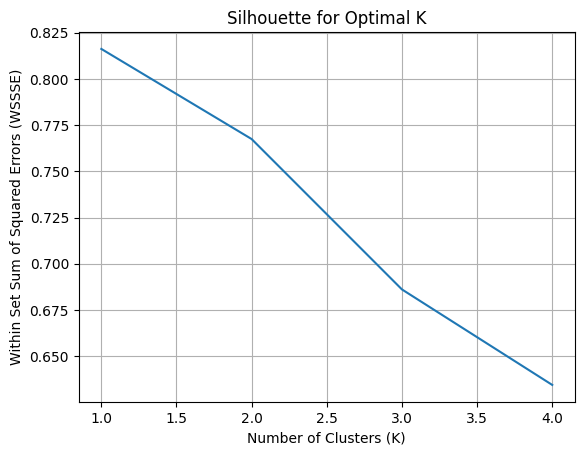

In [49]:
# Plotting WSSSE values
plt.plot(range(1, 7), wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Silhouette for Optimal K')
plt.grid()
plt.show()

In [50]:
# test the model with test data set
predictDf = kmeansModel.transform(testData)
predictDf.show(10)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictDf)
print("Silhouette with squared euclidean distance = " + str(silhouette))

+-------+------+-----+----+-------+------+----------------+----------+--------------------+----------+
|Channel|Region|Fresh|Milk|Grocery|Frozen|Detergents_Paper|Delicassen|            features|prediction|
+-------+------+-----+----+-------+------+----------------+----------+--------------------+----------+
|      1|     1| 1838|6380|   2824|  1218|            1216|       295|[6380.0,2824.0,12...|         1|
|      1|     1| 4155| 367|   1390|  2306|              86|       130| [367.0,1390.0,86.0]|         1|
|      1|     1| 5041|1115|   2856|  7496|             256|       375|[1115.0,2856.0,25...|         1|
|      1|     1| 5396|7503|  10646|    91|            4167|       239|[7503.0,10646.0,4...|         4|
|      1|     1| 8475|1931|   1883|  5004|            3593|       987|[1931.0,1883.0,35...|         1|
|      1|     1| 8656|2746|   2501|  6845|             694|       980|[2746.0,2501.0,69...|         1|
|      1|     1|11092|5008|   5249|   453|             392|       373|[50

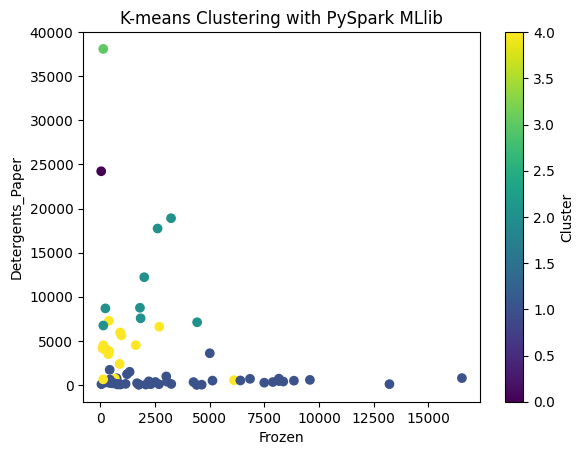

In [51]:
# Converting to Pandas DataFrame
clustered_data_pd = predictDf.toPandas()
# Visualizing the results
plt.scatter(clustered_data_pd["Frozen"], clustered_data_pd["Detergents_Paper"], c=clustered_data_pd["prediction"], cmap='viridis')
plt.xlabel("Frozen")
plt.ylabel("Detergents_Paper")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

In [52]:
import plotly.express as px

In [53]:
fig = px.scatter_3d(clustered_data_pd, x='Fresh', y='Milk', z='Grocery', color='prediction')
fig.show()